# Treatment Effect Estimation: From ATE to CATE

This notebook provides the theoretical background for understanding treatment effect estimation in causal inference, with a focus on applications to perturbation biology (e.g., Perturb-seq).

## Learning Objectives

1. Understand the **potential outcomes framework** (Rubin causal model)
2. Define **ATE** (Average Treatment Effect) and **CATE** (Conditional Average Treatment Effect)
3. Understand why **confounding** biases naive estimators
4. Learn the key estimation methods: **IPW**, **Doubly Robust**, **Meta-learners**
5. Connect theory to the `examples/01_treatment_effect_estimation.py` demo

## Table of Contents

1. [The Fundamental Problem of Causal Inference](#1-the-fundamental-problem-of-causal-inference)
2. [Potential Outcomes Framework](#2-potential-outcomes-framework)
3. [Average Treatment Effect (ATE)](#3-average-treatment-effect-ate)
4. [Confounding and Selection Bias](#4-confounding-and-selection-bias)
5. [ATE Estimation Methods](#5-ate-estimation-methods)
6. [Conditional Average Treatment Effect (CATE)](#6-conditional-average-treatment-effect-cate)
7. [CATE Estimation: Meta-Learners](#7-cate-estimation-meta-learners)
8. [Application: Perturb-seq Analysis](#8-application-perturb-seq-analysis)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

np.random.seed(42)

---

## 1. The Fundamental Problem of Causal Inference

### The Question We Want to Answer

> "What is the **causal effect** of treatment $T$ on outcome $Y$?"

In perturbation biology:
> "What is the causal effect of knocking out gene X on pathway activity Y?"

### Why This Is Hard

For any individual unit (cell, patient), we can only observe **one** of two possible outcomes:

- $Y(1)$: outcome if treated
- $Y(0)$: outcome if not treated

We **never** observe both for the same unit. This is the **fundamental problem of causal inference**.

### The Counterfactual

The outcome we don't observe is called the **counterfactual**:

- If a cell received the knockout ($T=1$), we observe $Y(1)$ but not $Y(0)$
- The question "what would $Y$ have been without the knockout?" is counterfactual

In [2]:
# Illustration: The fundamental problem
# We'll simulate data where we KNOW both potential outcomes (God's view)
# But in practice, we only observe one

n = 10
rng = np.random.default_rng(42)

# True potential outcomes (normally unobservable)
Y0 = rng.normal(5, 1, n)  # Outcome under control
Y1 = Y0 + 2 + rng.normal(0, 0.5, n)  # Outcome under treatment (effect ≈ 2)

# Treatment assignment
T = rng.binomial(1, 0.5, n)
# `1` = number of trials per sample (so each result is 0 or 1)

# What we actually observe
Y_observed = np.where(T == 1, Y1, Y0)

# Display
df = pd.DataFrame({
    'Unit': range(1, n+1),
    'T': T,
    'Y(0)': Y0.round(2),
    'Y(1)': Y1.round(2),
    'Y_observed': Y_observed.round(2),
    'ITE': (Y1 - Y0).round(2),  # Individual Treatment Effect
})

# Mark unobserved counterfactuals
df['Y(0)_status'] = np.where(T == 0, 'observed', 'counterfactual')
df['Y(1)_status'] = np.where(T == 1, 'observed', 'counterfactual')

print("The Fundamental Problem of Causal Inference")
print("=" * 60)
print(df[['Unit', 'T', 'Y(0)', 'Y(1)', 'Y_observed', 'ITE']].to_string(index=False))
print("\nNote: In reality, we only observe Y_observed, not both Y(0) and Y(1)")
print(f"\nTrue ATE (God's view): {(Y1 - Y0).mean():.3f}")

The Fundamental Problem of Causal Inference
 Unit  T  Y(0)  Y(1)  Y_observed  ITE
    1  1  5.30  7.74        7.74 2.44
    2  0  3.96  6.35        3.96 2.39
    3  1  5.75  7.78        7.78 2.03
    4  1  5.94  8.50        8.50 2.56
    5  1  3.05  5.28        5.28 2.23
    6  0  3.70  5.27        3.70 1.57
    7  0  5.13  7.31        5.13 2.18
    8  0  4.68  6.20        4.68 1.52
    9  0  4.98  7.42        4.98 2.44
   10  1  4.15  6.12        6.12 1.98

Note: In reality, we only observe Y_observed, not both Y(0) and Y(1)

True ATE (God's view): 2.135


---

## 2. Potential Outcomes Framework

The **Rubin Causal Model** (potential outcomes framework) formalizes causal inference.

### Notation

For each unit $i$:

| Symbol | Meaning |
|--------|--------|
| $T_i$ | Treatment indicator (0 or 1) |
| $Y_i(0)$ | Potential outcome under control |
| $Y_i(1)$ | Potential outcome under treatment |
| $X_i$ | Covariates (pre-treatment variables) |
| $Y_i$ | Observed outcome = $T_i \cdot Y_i(1) + (1-T_i) \cdot Y_i(0)$ |

### Individual Treatment Effect (ITE)

$$\tau_i = Y_i(1) - Y_i(0)$$

This is the causal effect for unit $i$. **We can never observe this directly.**

### Key Assumptions

To identify causal effects from observational data, we need:

1. **SUTVA** (Stable Unit Treatment Value Assumption)
   - No interference between units
   - No hidden versions of treatment

2. **Consistency**
   - $Y_i = Y_i(T_i)$ — observed outcome equals the potential outcome for the treatment received

3. **Ignorability** (Unconfoundedness)
   - $(Y(0), Y(1)) \perp\!\!\!\perp T \mid X$
   - Given covariates, treatment is as good as random

4. **Positivity** (Overlap)
   - $0 < P(T=1 \mid X) < 1$ for all $X$
   - Every unit has some chance of receiving either treatment

---

## 3. Average Treatment Effect (ATE)

Since we can't observe individual effects, we focus on **population averages**.

### Definition

$$\text{ATE} = \mathbb{E}[Y(1) - Y(0)] = \mathbb{E}[Y(1)] - \mathbb{E}[Y(0)]$$

This is the average causal effect across the population.

### Related Quantities

| Estimand | Definition | Interpretation |
|----------|------------|----------------|
| **ATE** | $\mathbb{E}[Y(1) - Y(0)]$ | Effect for random person |
| **ATT** | $\mathbb{E}[Y(1) - Y(0) \mid T=1]$ | Effect for those who got treated |
| **ATC** | $\mathbb{E}[Y(1) - Y(0) \mid T=0]$ | Effect for those who didn't get treated |

### Why ATE Matters for Drug Discovery

In perturbation biology:
- **ATE** answers: "On average, does knocking out gene X affect pathway Y?"
- This helps prioritize targets for further validation

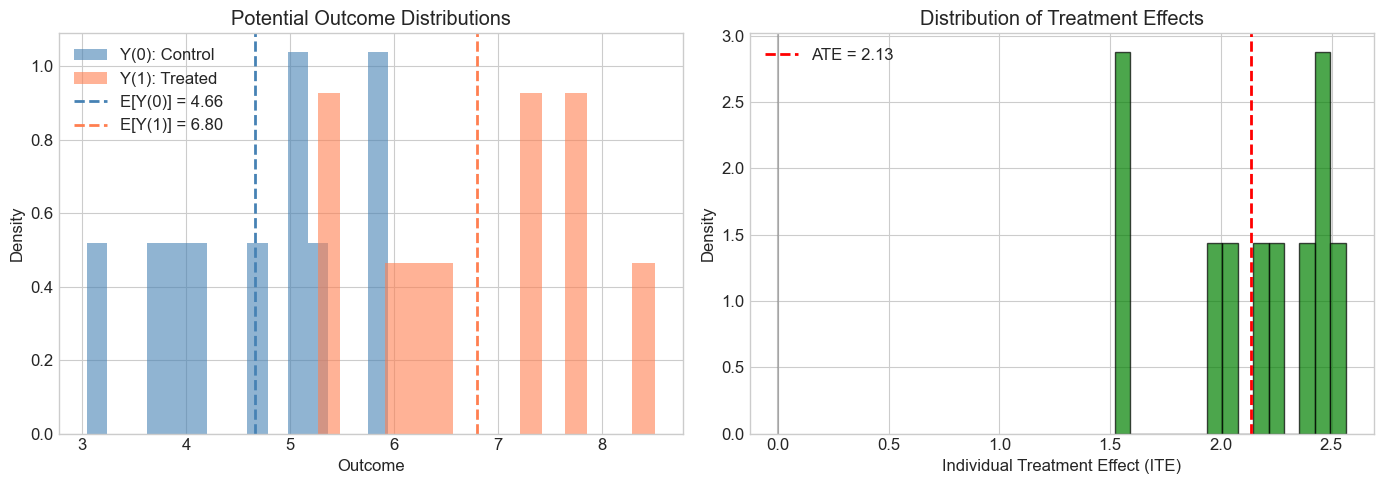

True ATE: 2.135
ITE range: [1.521, 2.564]


In [3]:
# Visualizing ATE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution of potential outcomes
ax = axes[0]
ax.hist(Y0, bins=15, alpha=0.6, label='Y(0): Control', color='steelblue', density=True)
ax.hist(Y1, bins=15, alpha=0.6, label='Y(1): Treated', color='coral', density=True)
ax.axvline(Y0.mean(), color='steelblue', linestyle='--', lw=2, label=f'E[Y(0)] = {Y0.mean():.2f}')
ax.axvline(Y1.mean(), color='coral', linestyle='--', lw=2, label=f'E[Y(1)] = {Y1.mean():.2f}')
ax.set_xlabel('Outcome')
ax.set_ylabel('Density')
ax.set_title('Potential Outcome Distributions')
ax.legend()

# Right: Individual treatment effects
ax = axes[1]
ite = Y1 - Y0
ax.hist(ite, bins=15, alpha=0.7, color='green', edgecolor='black', density=True)
ax.axvline(ite.mean(), color='red', linestyle='--', lw=2, label=f'ATE = {ite.mean():.2f}')
ax.axvline(0, color='gray', linestyle='-', alpha=0.5)
ax.set_xlabel('Individual Treatment Effect (ITE)')
ax.set_ylabel('Density')
ax.set_title('Distribution of Treatment Effects')
ax.legend()

plt.tight_layout()
plt.show()

print(f"True ATE: {ite.mean():.3f}")
print(f"ITE range: [{ite.min():.3f}, {ite.max():.3f}]")

---

## 4. Confounding and Selection Bias

### The Naive Estimator

The simplest approach: compare treated vs. control means.

$$\hat{\tau}_{\text{naive}} = \bar{Y}_{T=1} - \bar{Y}_{T=0}$$

### When Does This Work?

Only when treatment is **randomly assigned** (like in an RCT).

### What Is Confounding?

A **confounder** is a variable that:
1. Affects treatment assignment
2. Affects the outcome
3. Is not on the causal path from treatment to outcome

```
    Confounder (X)
      /      \
     ↓        ↓
Treatment → Outcome
   (T)        (Y)
```

### Confounding in Perturb-seq

Even in "randomized" perturbation experiments, confounding can arise from:

- **Library size**: Cells with higher counts may be assigned differently
- **Cell quality**: Dying cells may respond differently to perturbations
- **Batch effects**: Technical variation across experimental batches
- **Cell cycle**: Cells in different phases respond differently

In [4]:
# Demonstration: Confounding biases the naive estimator

def simulate_confounded_data(n=1000, true_ate=2.0, confounding_strength=0.5, seed=42):
    """Simulate data with confounding.
    
    X (confounder) affects both T and Y.
    """
    rng = np.random.default_rng(seed)
    
    # Confounder (e.g., library size)
    X = rng.normal(0, 1, n)
    
    # Treatment probability depends on X (confounding)
    propensity = 1 / (1 + np.exp(-confounding_strength * X))
    T = rng.binomial(1, propensity)
    
    # Potential outcomes
    # Y(0) depends on X (confounder affects outcome)
    Y0 = 5 + 1.5 * X + rng.normal(0, 1, n)
    # Y(1) = Y(0) + true treatment effect
    Y1 = Y0 + true_ate
    
    # Observed outcome
    Y = np.where(T == 1, Y1, Y0)
    
    return X, T, Y, Y0, Y1, propensity

# Simulate
true_ate = 2.0
X, T, Y, Y0, Y1, propensity = simulate_confounded_data(n=2000, true_ate=true_ate, confounding_strength=1.0)

# Naive estimate
naive_ate = Y[T == 1].mean() - Y[T == 0].mean()

print("Confounding Demonstration")
print("=" * 50)
print(f"True ATE:  {true_ate:.3f}")
print(f"Naive ATE: {naive_ate:.3f}")
print(f"Bias:      {naive_ate - true_ate:+.3f}")
print("\nThe naive estimator is BIASED because of confounding!")

Confounding Demonstration
True ATE:  2.000
Naive ATE: 3.297
Bias:      +1.297

The naive estimator is BIASED because of confounding!


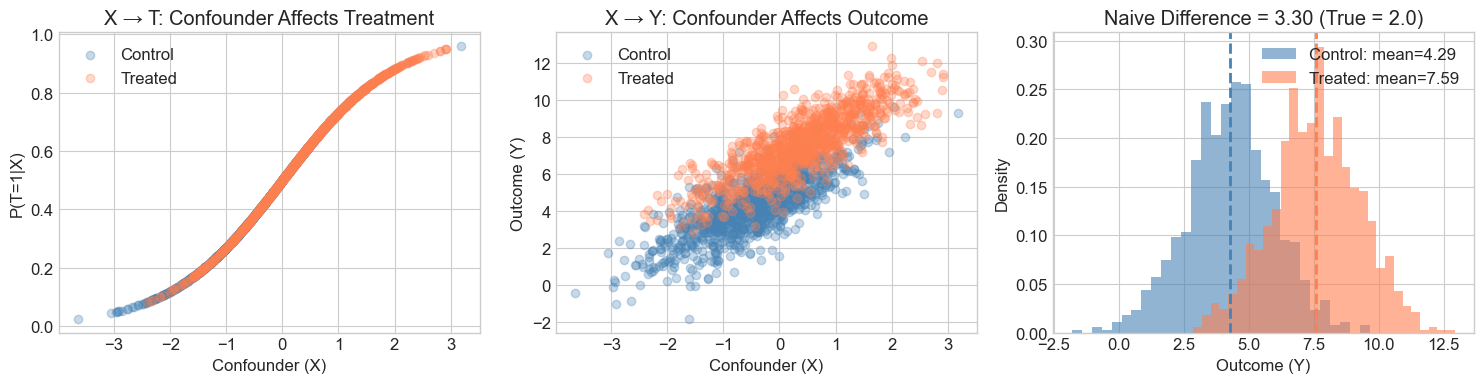

In [5]:
# Visualize the confounding
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confounder affects treatment
ax = axes[0]
ax.scatter(X[T==0], propensity[T==0], alpha=0.3, label='Control', c='steelblue')
ax.scatter(X[T==1], propensity[T==1], alpha=0.3, label='Treated', c='coral')
ax.set_xlabel('Confounder (X)')
ax.set_ylabel('P(T=1|X)')
ax.set_title('X → T: Confounder Affects Treatment')
ax.legend()

# 2. Confounder affects outcome
ax = axes[1]
ax.scatter(X[T==0], Y[T==0], alpha=0.3, label='Control', c='steelblue')
ax.scatter(X[T==1], Y[T==1], alpha=0.3, label='Treated', c='coral')
ax.set_xlabel('Confounder (X)')
ax.set_ylabel('Outcome (Y)')
ax.set_title('X → Y: Confounder Affects Outcome')
ax.legend()

# 3. Naive comparison is biased
ax = axes[2]
ax.hist(Y[T==0], bins=30, alpha=0.6, label=f'Control: mean={Y[T==0].mean():.2f}', color='steelblue', density=True)
ax.hist(Y[T==1], bins=30, alpha=0.6, label=f'Treated: mean={Y[T==1].mean():.2f}', color='coral', density=True)
ax.axvline(Y[T==0].mean(), color='steelblue', linestyle='--', lw=2)
ax.axvline(Y[T==1].mean(), color='coral', linestyle='--', lw=2)
ax.set_xlabel('Outcome (Y)')
ax.set_ylabel('Density')
ax.set_title(f'Naive Difference = {naive_ate:.2f} (True = {true_ate})')
ax.legend()

plt.tight_layout()
plt.show()

---

## 5. ATE Estimation Methods

To correct for confounding, we need more sophisticated estimators.

### 5.1 Inverse Propensity Weighting (IPW)

**Idea:** Reweight observations to create a "pseudo-population" where treatment is independent of confounders.

**Propensity score:** $e(X) = P(T=1 \mid X)$

**IPW estimator:**

$$\hat{\tau}_{\text{IPW}} = \frac{1}{n} \sum_{i=1}^n \left[ \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right]$$

**Intuition:** 
- Treated units with low propensity (unlikely to be treated) get upweighted
- This balances the covariate distribution between groups

### 5.2 Outcome Regression

**Idea:** Model the outcome as a function of covariates and treatment, then predict counterfactuals.

$$\hat{\tau}_{\text{reg}} = \frac{1}{n} \sum_{i=1}^n \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) \right]$$

Where:
- $\hat{\mu}_1(X) = \mathbb{E}[Y \mid X, T=1]$
- $\hat{\mu}_0(X) = \mathbb{E}[Y \mid X, T=0]$

### 5.3 Doubly Robust (AIPW)

**Idea:** Combine IPW and outcome regression. Consistent if **either** model is correct.

$$\hat{\tau}_{\text{DR}} = \frac{1}{n} \sum_{i=1}^n \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{T_i(Y_i - \hat{\mu}_1(X_i))}{e(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)} \right]$$

**This is the recommended estimator for observational data.**

In [6]:
# Implement the three estimators
from sklearn.linear_model import LogisticRegression, LinearRegression

def naive_ate(T, Y):
    """Simple difference in means."""
    return Y[T == 1].mean() - Y[T == 0].mean()

def ipw_ate(X, T, Y, clip=(0.01, 0.99)):
    """Inverse Propensity Weighting."""
    # Fit propensity model
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X.reshape(-1, 1), T)
    e = ps_model.predict_proba(X.reshape(-1, 1))[:, 1]
    e = np.clip(e, *clip)
    
    # IPW estimator
    ate = (T * Y / e).mean() - ((1 - T) * Y / (1 - e)).mean()
    return ate

def doubly_robust_ate(X, T, Y, clip=(0.01, 0.99)):
    """Doubly Robust (AIPW) estimator."""
    n = len(Y)
    X_2d = X.reshape(-1, 1)
    
    # Fit propensity model
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X_2d, T)
    e = ps_model.predict_proba(X_2d)[:, 1]
    e = np.clip(e, *clip)
    
    # Fit outcome models
    X_aug = np.column_stack([X, T])
    outcome_model = LinearRegression()
    outcome_model.fit(X_aug, Y)
    
    mu_1 = outcome_model.predict(np.column_stack([X, np.ones(n)]))
    mu_0 = outcome_model.predict(np.column_stack([X, np.zeros(n)]))
    
    # Doubly robust estimator
    psi = (mu_1 - mu_0 
           + T * (Y - mu_1) / e 
           - (1 - T) * (Y - mu_0) / (1 - e))
    
    return psi.mean()

# Compare estimators
print("ATE Estimation Comparison")
print("=" * 50)
print(f"True ATE:        {true_ate:.4f}")
print(f"Naive:           {naive_ate(T, Y):.4f}  (biased!)")
print(f"IPW:             {ipw_ate(X, T, Y):.4f}")
print(f"Doubly Robust:   {doubly_robust_ate(X, T, Y):.4f}")

ATE Estimation Comparison
True ATE:        2.0000
Naive:           3.2971  (biased!)
IPW:             2.1013
Doubly Robust:   2.0418


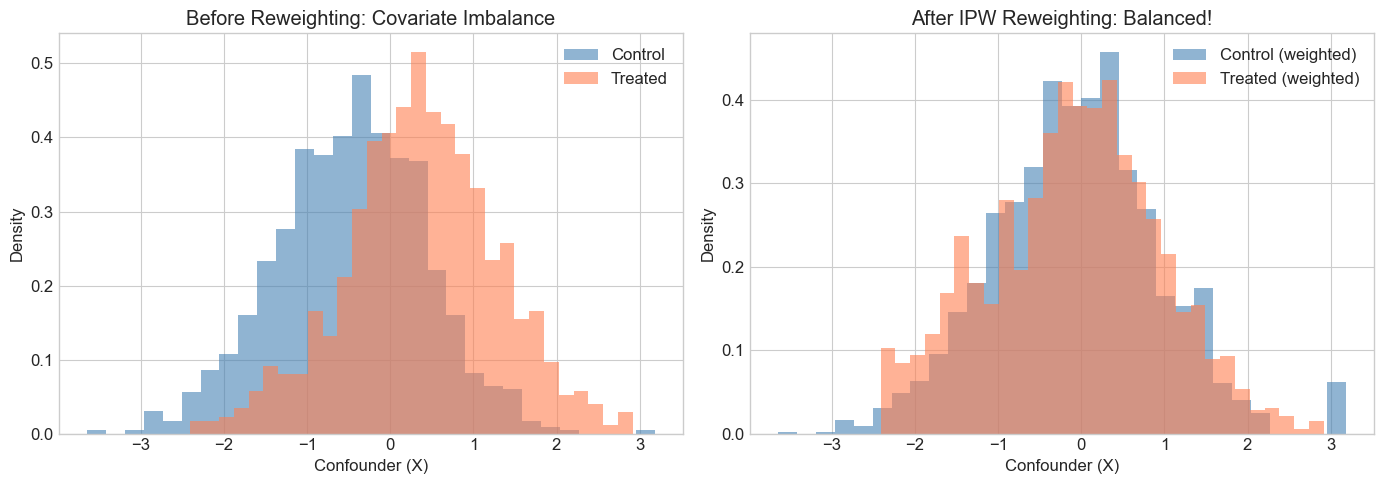

In [7]:
# Visualize: How IPW reweighting works
from sklearn.linear_model import LogisticRegression

# Estimate propensity scores
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X.reshape(-1, 1), T)
e_hat = ps_model.predict_proba(X.reshape(-1, 1))[:, 1]

# Compute IPW weights
weights = np.where(T == 1, 1/e_hat, 1/(1-e_hat))
weights = weights / weights.sum() * len(weights)  # Normalize

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before reweighting
ax = axes[0]
ax.hist(X[T==0], bins=30, alpha=0.6, label='Control', color='steelblue', density=True)
ax.hist(X[T==1], bins=30, alpha=0.6, label='Treated', color='coral', density=True)
ax.set_xlabel('Confounder (X)')
ax.set_ylabel('Density')
ax.set_title('Before Reweighting: Covariate Imbalance')
ax.legend()

# After reweighting
ax = axes[1]
ax.hist(X[T==0], bins=30, alpha=0.6, label='Control (weighted)', color='steelblue', 
        density=True, weights=weights[T==0])
ax.hist(X[T==1], bins=30, alpha=0.6, label='Treated (weighted)', color='coral', 
        density=True, weights=weights[T==1])
ax.set_xlabel('Confounder (X)')
ax.set_ylabel('Density')
ax.set_title('After IPW Reweighting: Balanced!')
ax.legend()

plt.tight_layout()
plt.show()

---

## 6. Conditional Average Treatment Effect (CATE)

### Beyond Average Effects

ATE tells us the **average** effect, but treatment effects often **vary** across individuals.

### Definition

$$\tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]$$

CATE is the expected treatment effect for individuals with covariates $X = x$.

### Why CATE Matters

| Question | Estimand |
|----------|----------|
| Does the drug work on average? | ATE |
| Which patients benefit most? | CATE |
| Should we treat this specific patient? | ITE (approximated by CATE) |

### CATE in Perturbation Biology

- **ATE:** "Does knocking out gene X affect pathway Y on average?"
- **CATE:** "In which cell states does the knockout have the largest effect?"

This is crucial for:
- Identifying **responder subpopulations**
- Understanding **context-dependent** gene function
- Precision medicine applications

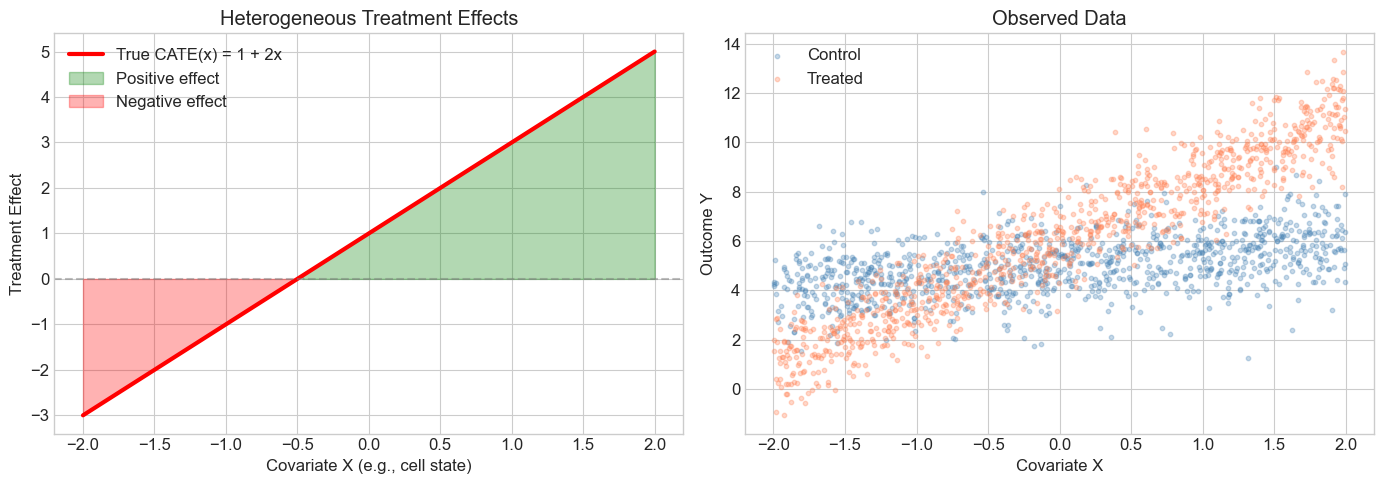

True ATE: 1.023
CATE range: [-2.996, 4.995]

Note: Effect is negative for X < -0.5, positive for X > -0.5


In [8]:
# Simulate heterogeneous treatment effects
def simulate_heterogeneous_effects(n=2000, seed=42):
    """Treatment effect varies with X."""
    rng = np.random.default_rng(seed)
    
    # Covariate (e.g., cell state score)
    X = rng.uniform(-2, 2, n)
    
    # Treatment (randomized for simplicity)
    T = rng.binomial(1, 0.5, n)
    
    # Heterogeneous treatment effect: larger effect for high X
    true_cate = 1 + 2 * X  # CATE(x) = 1 + 2x
    
    # Potential outcomes
    Y0 = 5 + 0.5 * X + rng.normal(0, 1, n)
    Y1 = Y0 + true_cate
    
    # Observed
    Y = np.where(T == 1, Y1, Y0)
    
    return X, T, Y, true_cate

X_het, T_het, Y_het, true_cate = simulate_heterogeneous_effects()

# Visualize heterogeneity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: True CATE function
ax = axes[0]
x_grid = np.linspace(-2, 2, 100)
cate_grid = 1 + 2 * x_grid
ax.plot(x_grid, cate_grid, 'r-', lw=3, label='True CATE(x) = 1 + 2x')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.fill_between(x_grid, 0, cate_grid, where=cate_grid > 0, alpha=0.3, color='green', label='Positive effect')
ax.fill_between(x_grid, 0, cate_grid, where=cate_grid < 0, alpha=0.3, color='red', label='Negative effect')
ax.set_xlabel('Covariate X (e.g., cell state)')
ax.set_ylabel('Treatment Effect')
ax.set_title('Heterogeneous Treatment Effects')
ax.legend()

# Right: Observed data
ax = axes[1]
ax.scatter(X_het[T_het==0], Y_het[T_het==0], alpha=0.3, label='Control', c='steelblue', s=10)
ax.scatter(X_het[T_het==1], Y_het[T_het==1], alpha=0.3, label='Treated', c='coral', s=10)
ax.set_xlabel('Covariate X')
ax.set_ylabel('Outcome Y')
ax.set_title('Observed Data')
ax.legend()

plt.tight_layout()
plt.show()

print(f"True ATE: {true_cate.mean():.3f}")
print(f"CATE range: [{true_cate.min():.3f}, {true_cate.max():.3f}]")
print(f"\nNote: Effect is negative for X < -0.5, positive for X > -0.5")

---

## 7. CATE Estimation: Meta-Learners

**Meta-learners** use standard ML models to estimate CATE.

### 7.1 S-Learner (Single Model)

**Idea:** Fit one model with treatment as a feature.

$$\hat{\mu}(x, t) = \mathbb{E}[Y \mid X=x, T=t]$$

$$\hat{\tau}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0)$$

**Pros:** Simple, uses all data  
**Cons:** May underestimate heterogeneity if treatment effect is small

### 7.2 T-Learner (Two Models)

**Idea:** Fit separate models for treated and control.

$$\hat{\mu}_0(x) = \mathbb{E}[Y \mid X=x, T=0]$$
$$\hat{\mu}_1(x) = \mathbb{E}[Y \mid X=x, T=1]$$
$$\hat{\tau}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$$

**Pros:** Better at capturing heterogeneity  
**Cons:** Requires sufficient samples in both arms

### 7.3 X-Learner

**Idea:** Impute counterfactuals, then fit effect models.

1. Fit $\hat{\mu}_0$ and $\hat{\mu}_1$ (like T-learner)
2. Impute effects:
   - For treated: $\tilde{D}_1 = Y_1 - \hat{\mu}_0(X_1)$
   - For control: $\tilde{D}_0 = \hat{\mu}_1(X_0) - Y_0$
3. Fit effect models on imputed effects
4. Combine using propensity weighting

**Pros:** Works well with imbalanced treatment groups  
**Cons:** More complex

### 7.4 Doubly Robust CATE (DR-Learner)

**Idea:** Use AIPW pseudo-outcomes, then fit a model.

$$\tilde{Y}_i = \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{T_i(Y_i - \hat{\mu}_1(X_i))}{e(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)}$$

Then fit: $\hat{\tau}(x) = \mathbb{E}[\tilde{Y} \mid X=x]$

**Pros:** Most robust, consistent under weaker conditions  
**Cons:** Requires good propensity and outcome models

In [9]:
# Implement meta-learners
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone

class SLearner:
    def __init__(self, base_model=None):
        self.model = base_model or GradientBoostingRegressor(n_estimators=100, max_depth=3)
    
    def fit(self, X, T, Y):
        X_aug = np.column_stack([X, T])
        self.model.fit(X_aug, Y)
        return self
    
    def predict(self, X):
        n = len(X)
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        y1 = self.model.predict(np.column_stack([X, np.ones(n)]))
        y0 = self.model.predict(np.column_stack([X, np.zeros(n)]))
        return y1 - y0

class TLearner:
    def __init__(self, base_model=None):
        base = base_model or GradientBoostingRegressor(n_estimators=100, max_depth=3)
        self.model_0 = clone(base)
        self.model_1 = clone(base)
    
    def fit(self, X, T, Y):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        self.model_0.fit(X[T == 0], Y[T == 0])
        self.model_1.fit(X[T == 1], Y[T == 1])
        return self
    
    def predict(self, X):
        X = X.reshape(-1, 1) if X.ndim == 1 else X
        return self.model_1.predict(X) - self.model_0.predict(X)

# Fit and compare
X_2d = X_het.reshape(-1, 1)

s_learner = SLearner().fit(X_2d, T_het, Y_het)
t_learner = TLearner().fit(X_2d, T_het, Y_het)

cate_s = s_learner.predict(X_2d)
cate_t = t_learner.predict(X_2d)

# Evaluate
print("CATE Estimation Comparison")
print("=" * 50)
print(f"{'Method':<15} {'ATE':>10} {'RMSE':>10} {'Correlation':>12}")
print("-" * 50)

for name, cate_hat in [('S-Learner', cate_s), ('T-Learner', cate_t)]:
    ate = cate_hat.mean()
    rmse = np.sqrt(((cate_hat - true_cate) ** 2).mean())
    corr = np.corrcoef(cate_hat, true_cate)[0, 1]
    print(f"{name:<15} {ate:>10.3f} {rmse:>10.3f} {corr:>12.3f}")

print("-" * 50)
print(f"{'True':>15} {true_cate.mean():>10.3f}")

CATE Estimation Comparison
Method                 ATE       RMSE  Correlation
--------------------------------------------------
S-Learner            1.076      0.221        0.996
T-Learner            1.097      0.348        0.990
--------------------------------------------------
           True      1.023


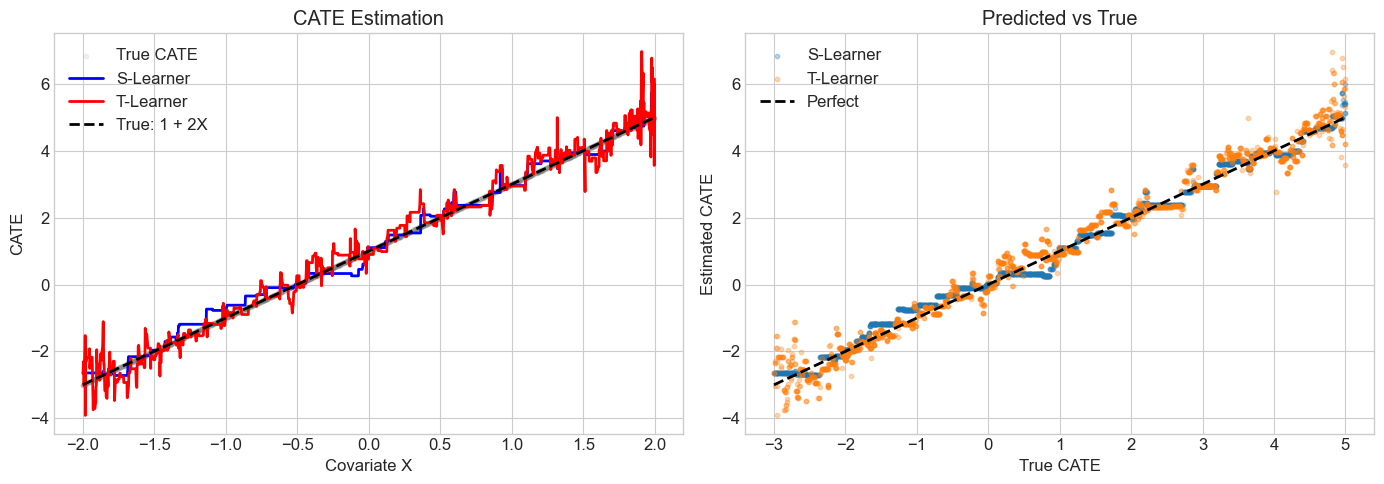

In [10]:
# Visualize CATE estimates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort by X for plotting
sort_idx = np.argsort(X_het)
X_sorted = X_het[sort_idx]

# Left: CATE estimates vs true
ax = axes[0]
ax.scatter(X_het, true_cate, alpha=0.1, s=10, c='gray', label='True CATE')
ax.plot(X_sorted, cate_s[sort_idx], 'b-', lw=2, label='S-Learner')
ax.plot(X_sorted, cate_t[sort_idx], 'r-', lw=2, label='T-Learner')
ax.plot(X_sorted, 1 + 2*X_sorted, 'k--', lw=2, label='True: 1 + 2X')
ax.set_xlabel('Covariate X')
ax.set_ylabel('CATE')
ax.set_title('CATE Estimation')
ax.legend()

# Right: Predicted vs True CATE
ax = axes[1]
ax.scatter(true_cate, cate_s, alpha=0.3, s=10, label='S-Learner')
ax.scatter(true_cate, cate_t, alpha=0.3, s=10, label='T-Learner')
ax.plot([-3, 5], [-3, 5], 'k--', lw=2, label='Perfect')
ax.set_xlabel('True CATE')
ax.set_ylabel('Estimated CATE')
ax.set_title('Predicted vs True')
ax.legend()

plt.tight_layout()
plt.show()

---

## 8. Application: Perturb-seq Analysis

Now let's connect this to the demo script `examples/01_treatment_effect_estimation.py`.

### The Setup

In Perturb-seq:
- **Treatment $T$:** Gene knockout (1) vs. control (0)
- **Outcome $Y$:** Pathway activity score
- **Covariates $X$:** Library size, cell quality metrics

### Why Confounding Exists

Even in "randomized" experiments:
- **Library size** affects both perturbation efficiency and gene expression
- **Cell quality** affects survival and response
- **Batch effects** create systematic differences

### The Demo Script Workflow

```python
# 1. Generate synthetic data with known ground truth
X, T, Y, metadata = generate_synthetic_perturbation_data(
    n_cells=3000,
    effect_sizes=[2.0, -1.5, 0.5, 0.0, -2.5],
    confounding_strength=0.4,
)

# 2. Compare ATE estimators
results = compare_estimators(X, T_binary, Y)

# 3. Key insight: Doubly robust corrects for confounding
```

### Using the causalbiolab Package

In [11]:
# Import from causalbiolab (if installed)
try:
    from causalbiolab.estimation import (
        NaiveATE, PropensityATE, DoublyRobustATE,
        compare_estimators, print_comparison,
    )
    CAUSALBIOLAB_AVAILABLE = True
except ImportError:
    CAUSALBIOLAB_AVAILABLE = False
    print("causalbiolab not installed. Using local implementations.")

if CAUSALBIOLAB_AVAILABLE:
    # Use the package
    results = compare_estimators(X.reshape(-1, 1), T, Y)
    print_comparison(results)
    print(f"\nTrue ATE: {true_ate:.4f}")


ATE Estimation Comparison
Method                      ATE         SE                    95% CI
----------------------------------------------------------------------
naive_difference         3.2971     0.0754          [3.1493, 3.4448]
ipw                      2.1013     0.3365          [1.4419, 2.7608]
doubly_robust            2.0435     0.0504          [1.9446, 2.1423]
N treated: 984, N control: 1016

True ATE: 2.0000


In [12]:
# Simulate Perturb-seq-like data
def generate_perturbseq_data(n_cells=2000, true_effect=2.0, confounding=0.4, seed=42):
    """Simulate Perturb-seq data with library size confounding."""
    rng = np.random.default_rng(seed)
    
    # Library size (log-normal, realistic for scRNA-seq)
    log_lib = rng.normal(10, 0.5, n_cells)
    
    # Confounded treatment: high library size -> more likely treated
    z = confounding * (log_lib - log_lib.mean()) / log_lib.std()
    propensity = 1 / (1 + np.exp(-z))
    T = rng.binomial(1, propensity)
    
    # Outcome: pathway score
    # Confounding: library size affects pathway score
    baseline = 5 + 0.5 * (log_lib - log_lib.mean())
    Y = baseline + true_effect * T + rng.normal(0, 1, n_cells)
    
    return log_lib, T, Y, propensity

# Generate data
true_effect = 2.0
log_lib, T_ps, Y_ps, prop_ps = generate_perturbseq_data(true_effect=true_effect)

# Compare estimators
print("Perturb-seq ATE Estimation")
print("=" * 50)
print(f"True effect: {true_effect:.4f}")
print(f"Naive:       {naive_ate(T_ps, Y_ps):.4f}")
print(f"IPW:         {ipw_ate(log_lib, T_ps, Y_ps):.4f}")
print(f"DR:          {doubly_robust_ate(log_lib, T_ps, Y_ps):.4f}")

Perturb-seq ATE Estimation
True effect: 2.0000
Naive:       2.1144
IPW:         2.0326
DR:          2.0142


---

## Summary

### Key Concepts

| Concept | Definition |
|---------|------------|
| **Potential outcomes** | $Y(0), Y(1)$ — outcomes under control/treatment |
| **ITE** | $Y(1) - Y(0)$ — individual treatment effect (unobservable) |
| **ATE** | $\mathbb{E}[Y(1) - Y(0)]$ — average treatment effect |
| **CATE** | $\mathbb{E}[Y(1) - Y(0) \mid X]$ — conditional average treatment effect |
| **Confounding** | Variable affecting both treatment and outcome |
| **Propensity score** | $e(X) = P(T=1 \mid X)$ |

### Estimation Methods

| Method | Idea | When to use |
|--------|------|-------------|
| **Naive** | Difference in means | Only if truly randomized |
| **IPW** | Reweight by propensity | When propensity model is good |
| **Doubly Robust** | Combine IPW + outcome model | Default for observational data |
| **S-Learner** | Single model with T as feature | Simple CATE estimation |
| **T-Learner** | Separate models per arm | When heterogeneity is expected |
| **X-Learner** | Impute + combine | Imbalanced treatment groups |

### For Perturb-seq

1. **Always compare methods** — if they disagree, investigate confounding
2. **Doubly robust is safest** — protects against model misspecification
3. **CATE reveals biology** — which cell states respond to perturbation?

---

## Next Steps

- Run `examples/01_treatment_effect_estimation.py` to see these methods in action
- Explore CATE estimation with `causalbiolab.estimation.cate`
- See `02_cate_meta_learners.ipynb` for deeper dive into meta-learners